In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import ast

from pprint import pprint

import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset, join_queries_features

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
experiment = "results_workers_1_fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.1"

In [147]:
dataset_dir = use_dataset("ml-100k-features")
results_dir = use_results("ml-100k-features")
print(dataset_dir)
print(results_dir)

/data/wooders/ralf-vldb//datasets/ml-100k-features
/data/wooders/ralf-vldb//datasets/ml-100k-features
/data/wooders/ralf-vldb//results/ml-100k-features


In [351]:
feature_updates = pd.read_csv(f"{results_dir}/{experiment}.csv")

In [352]:
feature_updates["user_features"] = feature_updates["user_features"].apply(ast.literal_eval)

In [425]:
# create map to map timestamps -> real timestamps 
timestamp_to_ingest_time = dict(zip(feature_updates.timestamp, feature_updates.ingest_time))
#pprint(timestamp_to_ingest_time)

In [356]:
feature_updates

,user_id,user_features,ingest_time,timestamp,processing_time
0,712,"[0.0002096466615135222, 0.00028415484285569106...",1.645683e+09,0.0,1.645683e+09
1,23,"[0.1551610140794084, 0.05534532873818174, 0.39...",1.645683e+09,0.0,1.645683e+09
2,23,"[0.1558862970918417, 0.05535640001818538, 0.39...",1.645683e+09,0.0,1.645683e+09
3,23,"[0.15557652164489713, 0.05555409487916563, 0.3...",1.645683e+09,0.0,1.645683e+09
4,23,"[0.15682565615687008, 0.056276125762296236, 0....",1.645683e+09,0.0,1.645683e+09
...,...,...,...,...,...
0,939,"[0.05236969143152237, 0.06957797706127167, 0.1...",NaN,NaN,0.000000e+00
0,940,"[0.1037789061665535, 0.0, 0.3266943097114563, ...",NaN,NaN,0.000000e+00
0,941,"[0.3040238916873932, 0.16910012066364288, 0.15...",NaN,NaN,0.000000e+00
0,942,"[0.08065348118543625, 0.0980977863073349, 0.26...",NaN,NaN,0.000000e+00


## Read Batch Generated Features Data 

In [138]:
user_features_path = f"{dataset_dir}/user_features.csv"
movie_features_path = f"{dataset_dir}/movie_features.csv"
ratings_path = f"{dataset_dir}/ratings.csv"

In [139]:
def get_features(file_path):
    df = pd.read_csv(file_path)
    features = dict()
    for row in df.itertuples():
        features[row.id] = np.array(eval(row.features))
    return features 

In [140]:
def get_feature_update(features, row):
    features[row.user_id] = np.array(eval(row.user_features))

In [333]:
user_features = get_features(user_features_path)
movie_features = get_features(movie_features_path)

### Join with feature updates file 
This is to make sure every query gets matched to *some* user feature in later steps. 

In [357]:
for user_id in user_features.keys(): 
    # concate feature for time 0 
    row = pd.DataFrame({"user_id": user_id, "user_features": [user_features[user_id]], "processing_time": 0})
    feature_updates = pd.concat([feature_updates, row])

In [358]:
feature_updates.sort_values(by="processing_time")

,user_id,user_features,ingest_time,timestamp,processing_time
0,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.000000e+00
0,621,"[0.1755983680486679, 0.0, 0.27002421021461487,...",NaN,NaN,0.000000e+00
0,622,"[0.2228955328464508, 0.11773999780416489, 0.57...",NaN,NaN,0.000000e+00
0,623,"[0.0, 0.05122954398393631, 0.3077024519443512,...",NaN,NaN,0.000000e+00
0,624,"[0.34239625930786133, 0.0, 0.3182916045188904,...",NaN,NaN,0.000000e+00
...,...,...,...,...,...
49369,189,"[0.47163313324145284, 0.168040033012125, 0.576...",1.645683e+09,493.0,1.645683e+09
49370,189,"[0.47847857034944014, 0.16803789169600616, 0.5...",1.645683e+09,493.0,1.645683e+09
49371,189,"[0.47831930167041725, 0.16795552192906438, 0.5...",1.645683e+09,493.0,1.645683e+09
49372,189,"[0.4837641966762788, 0.16991983281024342, 0.58...",1.645683e+09,493.0,1.645683e+09


## Read Test Data (i.e. queries)

In [359]:
test_data = pd.read_csv(ratings_path)

In [360]:
# assign query timestamps based of ingest_time of feature timestamps 
queries_df = pd.DataFrame({
    "user_id": test_data.user_id, 
    "movie_id": test_data.movie_id, 
    "rating": test_data.rating, 
    "timestamp": test_data.timestamp, 
    "processing_time": test_data.timestamp.apply(lambda x: timestamp_to_ingest_time[x] if x in timestamp_to_ingest_time else None)
})
queries_df = queries_df.dropna()
queries_df["query_id"] = queries_df.index
queries_df

,user_id,movie_id,rating,timestamp,processing_time,query_id
0,712,506,3,0,1.645683e+09,0
1,23,739,2,0,1.645683e+09,1
2,23,530,4,0,1.645683e+09,2
3,23,211,4,0,1.645683e+09,3
4,23,511,5,0,1.645683e+09,4
...,...,...,...,...,...,...
49394,189,381,3,493,1.645683e+09,49394
49395,189,378,4,493,1.645683e+09,49395
49396,189,526,4,493,1.645683e+09,49396
49397,189,28,4,493,1.645683e+09,49397


### Modify query processing time 
Probably more realistic to add a slight delay between when the update is sent to ralf (ingest_time) and when the query is made? 

In [401]:
queries_df["processing_time"] = queries_df["processing_time"] + 1

### Join queries with feature updates 

In [402]:
tmp_joined_df = join_queries_features(queries_df, feature_updates, key_field="user_id", time_field="processing_time")

100%|██████████| 49399/49399 [01:07<00:00, 732.79it/s]


In [403]:
joined_df = tmp_joined_df.merge(queries_df, on=["query_id", "user_id"], suffixes=("_feature", "_query"))

In [405]:
joined_df

,user_id,user_features,ingest_time,timestamp_feature,processing_time_feature,query_id,query_user_id,query_timestamp,movie_id,rating,timestamp_query,processing_time_query
0,1,"[0.32145630734586167, 0.062321302718138974, 0....",1.645683e+09,55.0,1.645683e+09,4599,1.0,1.645683e+09,46,4,46,1.645683e+09
1,1,"[0.32145630734586167, 0.062321302718138974, 0....",1.645683e+09,55.0,1.645683e+09,4600,1.0,1.645683e+09,177,5,46,1.645683e+09
2,1,"[0.32145630734586167, 0.062321302718138974, 0....",1.645683e+09,55.0,1.645683e+09,4602,1.0,1.645683e+09,195,5,46,1.645683e+09
3,1,"[0.32145630734586167, 0.062321302718138974, 0....",1.645683e+09,55.0,1.645683e+09,4604,1.0,1.645683e+09,213,2,46,1.645683e+09
4,1,"[0.32145630734586167, 0.062321302718138974, 0....",1.645683e+09,55.0,1.645683e+09,4605,1.0,1.645683e+09,218,3,46,1.645683e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
49394,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.000000e+00,37291,943.0,1.645683e+09,229,2,372,1.645683e+09
49395,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.000000e+00,37292,943.0,1.645683e+09,449,1,372,1.645683e+09
49396,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.000000e+00,37293,943.0,1.645683e+09,234,3,372,1.645683e+09
49397,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.000000e+00,37294,943.0,1.645683e+09,151,4,372,1.645683e+09


### Evaluate on all queries 

In [407]:
joined_df.processing_time_feature.value_counts()

0.000000e+00    38595
1.645683e+09      160
1.645683e+09      147
1.645683e+09      132
1.645683e+09      129
                ...  
1.645683e+09        1
1.645683e+09        1
1.645683e+09        1
1.645683e+09        1
1.645683e+09        1
Name: processing_time_feature, Length: 432, dtype: int64

In [411]:
joined_df["prediction"] = joined_df.apply(
    lambda x: predict_rating(np.array(x["user_features"]), movie_features[x["movie_id"]])
, axis=1) 

In [412]:
joined_df["baseline_prediction"] = joined_df.apply(
    lambda x: predict_rating(user_features[x["user_id"]], movie_features[x["movie_id"]])
, axis=1) 

In [413]:
joined_df.processing_time_feature.value_counts()

0.000000e+00    38595
1.645683e+09      160
1.645683e+09      147
1.645683e+09      132
1.645683e+09      129
                ...  
1.645683e+09        1
1.645683e+09        1
1.645683e+09        1
1.645683e+09        1
1.645683e+09        1
Name: processing_time_feature, Length: 432, dtype: int64

In [414]:
mean_squared_error(joined_df["rating"], joined_df["prediction"])

0.9438907079113067

In [415]:
mean_squared_error(joined_df["rating"], joined_df["baseline_prediction"])

0.963470348046898

### Evaluate on queries of updated features 

In [429]:
joined_df_drop = joined_df[joined_df["processing_time_feature"] > 0]

In [430]:
staleness = joined_df_drop["processing_time_query"] - joined_df_drop["processing_time_feature"]
print("average staleness", staleness.mean())
joined_df_drop.processing_time_feature.value_counts()

average staleness 8.75897027322073


1.645683e+09    160
1.645683e+09    147
1.645683e+09    132
1.645683e+09    129
1.645683e+09    121
               ... 
1.645683e+09      1
1.645683e+09      1
1.645683e+09      1
1.645683e+09      1
1.645683e+09      1
Name: processing_time_feature, Length: 431, dtype: int64

In [427]:
mean_squared_error(joined_df_drop["rating"], joined_df_drop["prediction"])

0.8841771666746459

In [428]:
mean_squared_error(joined_df_drop["rating"], joined_df_drop["baseline_prediction"])

0.9737009211228203

# Old Evaluation 
Copied from Amit's Notebook

In [419]:
user_features = get_features(user_features_path)
movie_features = get_features(movie_features_path)

def predict_rating(user_feature, movie_feature):
    return user_feature.dot(movie_feature.T)

def compute_test_mse(user_features, movie_features):
    predictions = []
    ratings = []
    count = 0
    for row in test_data.itertuples():
        user_id = row.user_id
        movie_id = row.movie_id
        rating = row.rating
        predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
        ratings.append(rating) 
    mse = mean_squared_error(ratings, predictions)
    return mse

def compute_mse(user_features):
    predictions = []
    ratings = []
    for row in test_data.itertuples():
        user_id = row.user_id
        movie_id = row.movie_id
        rating = row.rating
        ratings.append(rating)
        predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
    return mean_squared_error(ratings, predictions)

def compute_improvement():
    count = 0
    predictions = []
    ratings = []
    max_timestamp = max(feature_updates['timestamp'])
    print(max_timestamp, len(feature_updates), len(test_data))
    baseline = compute_mse(user_features)
    
    
    num_updates = 0 
    while count <= max_timestamp:
        
        # 
        feature_update_ts = feature_updates[feature_updates['timestamp'] == count] 
        for row in feature_update_ts.itertuples():
            user_features[row.user_id] = np.array(row.user_features)
            num_updates += 1

        query_ts = test_data[test_data['timestamp'] == count]
        for row in query_ts.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
            ratings.append(rating)
        count += 1
    new_mse = mean_squared_error(ratings, predictions)
    optimal = compute_mse(user_features)
    
    return baseline, new_mse, optimal

In [421]:
def plot_learning_curve(mse):
        """visualize the training/testing loss"""
        linewidth = 3
        plt.plot(mse, label = 'Ralf', linewidth = linewidth)
        plt.xlabel('iterations')
        plt.ylabel('MSE')
        plt.legend(loc = 'best')

493.0 51260 49442


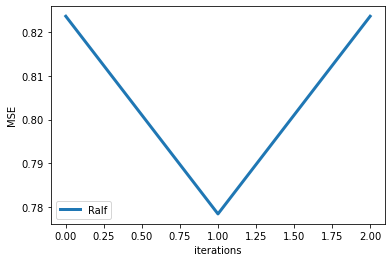

In [422]:
mse = compute_improvement()
plot_learning_curve(mse)